In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 0.20 (18-10-2022)' )

loaded gammapy version: 0.20 
Supposed to be 0.20 (18-10-2022)


In this notebook the angular size of the systematic is evaulated. Therefore, we compute the sqrt ts map of the standard anlysis and compute the 2D Fourier trafo of the first energybin. The obtained angular spectrum is compared with the one computed from a dataset consisting of statistical fluctuations only (asimov dataset). The spectrum of 1000 Poission draws of this asimov dataset are plotted and used for the standard deviation estimation of the anuglar spectrum points. 

In [2]:
import matplotlib.image as mpimg
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import astropy
from gammapy.maps import Map
from gammapy.datasets import MapDataset
from gammapy.modeling.models import Models, Model, SkyModel, FoVBackgroundModel
from gammapy.estimators import ExcessMapEstimator
from gammapy.modeling import Fit, Parameter, Parameters
from astropy.coordinates import SkyCoord, Angle
from regions import RectangleSkyRegion

import astropy.units as u
import yaml
import sys
#sys.path.append('/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters')

import my_dataset_maps_20


time: 6
spatial binsize =  [0.02] deg


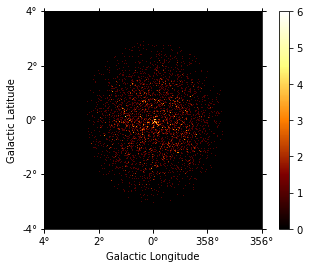

In [3]:
source = 'GC_dataset_zeta_5_muoneffTrue_edispTrue'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
source = 'GC_timedependent_'
time = '6'
source = source + time

if source == "Crab":

    # here the dataset with the fine binning is saved
    dataset = MapDataset.read(f'{path}/{source}/stacked.fits')
    dataset = dataset.downsample(4)
    models = Models.read(f"{source}/standard_model.yml")
    
    with open(f"{source}/nui_bgmodel.yml", "r") as ymlfile:
        best_fit_bgmodel = yaml.load(ymlfile, Loader=yaml.FullLoader)
    bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
    bkg_model.parameters['norm'].value = best_fit_bgmodel['spectral']['parameters'][0]['value']
    bkg_model.parameters['tilt'].value = best_fit_bgmodel['spectral']['parameters'][1]['value']
    bkg_model.parameters['norm'].error = best_fit_bgmodel['spectral']['parameters'][0]['error']
    bkg_model.parameters['tilt'].error = best_fit_bgmodel['spectral']['parameters'][1]['error']
    models.append(bkg_model)
    dataset.models = models


    
if "GC" in source:
    if source =="GC":
        path_GC ='/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/2-source_dataset/GC_0.19'
        dataset = MapDataset.read(f'{path_GC}/20220511_dataset002_hess1_muonflagTrue.fits')
        dataset.stack(MapDataset.read(f'{path_GC}/20220511_dataset002_hess2_muonflagTrue.fits'))
        dataset = dataset.downsample(4)
        
    if source == 'GC_dataset_zeta_1_muoneffTrue_edispTrue':
        path_GC = '/home/vault/caph/mppi062h/repositories/GC/HESS/datasets_fits'
        dataset = MapDataset.read(f'{path_GC}/dataset_zeta_1_muoneffTrue_edispTrue.fits')
   
    if source == 'GC_dataset_zeta_5_muoneffTrue_edispTrue':
        path_GC = '/home/vault/caph/mppi062h/repositories/GC/HESS/datasets_fits'
        dataset = MapDataset.read(f'{path_GC}/dataset_zeta_1_muoneffTrue_edispTrue.fits')
   
if 'GC_timedependent' in source:
    if time == 'fulltime':

        path_GC = '/home/vault/caph/mppi062h/repositories/GC/20221101/HESS/datasets_fits'
        dataset  =  MapDataset.read(f'{path_GC}/dataset_{time}.fits')
        model_name = '/home/vault/caph/mppi062h/repositories/GC/20221101/HESS/models/all_free_fulltime.yaml'
        models = Models.read(model_name)
        bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
        # set bg model parameters frozen
        bkg_model.parameters['tilt'].frozen  = True
        bkg_model.parameters['norm'].frozen  = True

        models.append(bkg_model)
        dataset.models = models

        #set diffuse emission free:
        dataset.models['diff-emission'].parameters['tilt'].frozen = False
    else:
        print("time:", time)
        path_GC = '/home/vault/caph/mppi062h/repositories/GC/20221101/HESS/datasets_fits'
        dataset  =  MapDataset.read(f'{path_GC}/dataset_{time}.fits')
        # read in the best fit model with the nuisance parameters 
        # From the fulltime analysis
        path_best_fit = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/2-source_dataset/GC_timedependent_fulltime/'
        best_fit_name = 'nui_model_002_45centralspectrumfree.yml'
        models = Models.read(path_best_fit+ best_fit_name)
        bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
        # set bg model parameters frozen
        bkg_model.parameters['tilt'].frozen  = True
        bkg_model.parameters['norm'].frozen  = True

        models.append(bkg_model)
        dataset.models = models

        #set diffuse emission free:
        dataset.models['diff-emission'].parameters['tilt'].frozen = True
        dataset.models['diff-emission'].parameters['norm'].frozen = True

    
    
dataset.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset.geoms["geom"].width[1] / dataset.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)


## Statistics Check

(24,)
sys_percent [  0.           0.           0.           0.          -8.66522188
  10.19079023   2.69154638   1.83614334   0.           0.
   0.          -4.54299041 -10.85421572   0.         -13.47661103
 -16.23769445 -23.32847417 -23.79376982 -24.3777769  -31.5239645
   0.           0.           0.           0.        ]
stat_percent [        nan         nan         nan         nan   1.8269321   1.9797856
   2.3857327   2.816357    3.393401    4.1283026   5.0950365   6.4246535
   8.130741   11.582658   16.901903   21.100157   27.135014   35.88431
  47.95825    63.847168   80.126915   98.80515   116.40877   130.06425  ]


/tmp/ipykernel_510563/2311417635.py:19: RuntimeWarning: invalid value encountered in true_divide
  stat_percent = stat_counts/ bg  * 100


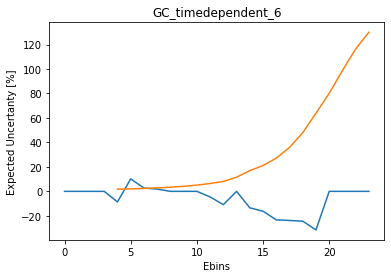

In [4]:

if 'GC_timedependent' in source:
    local_path_ = '/home/vault/caph/mppi062h/repositories/GC/20221101/HESS/systematic_levels'
    name = 'from_lookuptable_' + time + '_percentage.txt'
    sys_percent = np.loadtxt((f'{local_path_}/{name}'))
    
else:
    sys_percent = np.loadtxt((f'{local_path}/{source}/sysamplitude_percentage.txt'))
# Convert to %:


plt.plot(sys_percent, label = 'sys')
plt.ylabel("Expected Uncertanty [%]")
plt.xlabel("Ebins")
bg = dataset.background.data.sum(axis=2).sum(axis=1)
print(np.shape(sys_percent))
sys_counts = sys_percent * bg /100

stat_counts = np.sqrt(bg)  
stat_percent = stat_counts/ bg  * 100
print('sys_percent', sys_percent)
print("stat_percent", stat_percent )
plt.plot(stat_percent, label = 'stat')
fig = plt.gcf()
plt.title(source)
name = f'{source}'+'/plots/stat_sys_comparison_percent'  
fig.savefig(name+'.png', dpi=300, bbox_inches = 'tight')

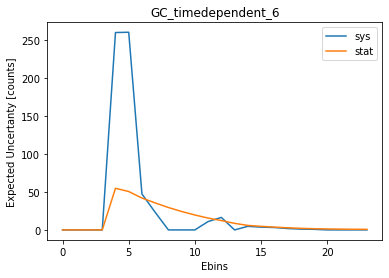

In [5]:
plt.plot(np.abs(sys_counts), label = "sys")
plt.plot(stat_counts, label = 'stat')
plt.ylabel("Expected Uncertanty [counts]")
plt.xlabel("Ebins")
plt.legend()
fig = plt.gcf()
plt.title(source)

name = f'{source}'+'/plots/stat_sys_comparison_counts'  
fig.savefig(name+'.png', dpi=300, bbox_inches = 'tight')